# imports

In [69]:
#standard ds imports
import pandas as pd
import numpy as np

#viz and stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

import env
import wrangle

from sklearn.model_selection import train_test_split

from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from math import sqrt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import viz



# 1

## load the zillow dataset 

In [70]:
from wrangle import get_connection
from wrangle import wrangle_zillow
from wrangle import get_zillow_data

df = get_zillow_data()
df = wrangle_zillow(df)
df.county = df.county.map({6037:'LA',6059:'Orange',6111:'Ventura'}) 
df.head()

,propertylandusedesc,bedrooms,bathrooms,area,taxvalue,yearbuilt,taxamount,county
4,Single Family Residential,4,2.0,3633,296425,2005,6941.39,LA
6,Single Family Residential,3,4.0,1620,847770,2011,10244.94,LA
7,Single Family Residential,3,2.0,2077,646760,1926,7924.68,LA
11,Single Family Residential,0,0.0,1200,5328,1972,91.60,LA
14,Single Family Residential,0,0.0,171,6920,1973,255.17,LA


# 2
## Fit a linear regression model (ordinary least squares) and compute yhat, predictions of taxvaluedollarcnt using only calculatedfinishedsqft.



In [57]:
def split_data(df):
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate,
                                       test_size=.3,
                                       random_state=123)
    return train, validate, test

In [58]:
train, validate, test = split_data(df)


print(f'train    -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test     -> {test.shape}')

train    -> (1198531, 8)
validate -> (513657, 8)
test     -> (428047, 8)


In [59]:
train.head()

,propertylandusedesc,bedrooms,bathrooms,area,taxvalue,yearbuilt,taxamount,county
1567873,Single Family Residential,3,1.0,1248,191578,1950,2712.21,LA
1218138,Single Family Residential,2,2.0,1326,1345206,1950,16539.04,LA
339661,Single Family Residential,2,1.0,1053,356648,1953,4575.16,LA
1017133,Single Family Residential,3,2.0,1256,175069,1946,2635.51,LA
40250,Single Family Residential,3,2.0,1640,543000,1957,6344.96,Orange


In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1198531 entries, 1567873 to 372341
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   propertylandusedesc  1198531 non-null  object 
 1   bedrooms             1198531 non-null  int64  
 2   bathrooms            1198531 non-null  float64
 3   area                 1198531 non-null  int64  
 4   taxvalue             1198531 non-null  int64  
 5   yearbuilt            1198531 non-null  int64  
 6   taxamount            1198531 non-null  float64
 7   county               1198531 non-null  object 
dtypes: float64(2), int64(4), object(2)
memory usage: 82.3+ MB


In [71]:
train = train[['area', 'taxvalue']].copy()
train.head(3)

,area,taxvalue
1567873,0.001309,191578
1218138,0.001391,1345206
339661,0.001104,356648


### now that I am looking at the columns I want I can scale the data 

In [65]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

mms = MinMaxScaler() # creeating the scaler 

train['area'] = mms.fit_transform(train[['area']]) # fitting and transforming the scaler to area


In [72]:
train.head()

,area,taxvalue
1567873,0.001309,191578
1218138,0.001391,1345206
339661,0.001104,356648
1017133,0.001317,175069
40250,0.001721,543000


In [73]:
train.area.min()

0.0

In [74]:
train.area.max()

1.0

In [75]:
#split into my X_train and y_train
X_train = train[['area']]
y_train = train.taxvalue

X_validate = validate[['area']]
y_validate = validate.taxvalue

X_test = test[['area']]
y_test = test.taxvalue

In [76]:
X_train.head() # verify

,area
1567873,0.001309
1218138,0.001391
339661,0.001104
1017133,0.001317
40250,0.001721


In [77]:
y_train.head() # verify

1567873     191578
1218138    1345206
339661      356648
1017133     175069
40250       543000
Name: taxvalue, dtype: int64

In [78]:
#make my ols model
from sklearn.linear_model import LinearRegression

model = LinearRegression() # creating the model
model.fit(X_train, y_train) # fitting the model
train['yhat'] = model.predict(X_train) # creating a new column in our dataframe for predictions 

In [79]:
train.head(3) # verifiy

,area,taxvalue,yhat
1567873,0.001309,191578,331576.623967
1218138,0.001391,1345206,348001.978672
339661,0.001104,356648,290513.237203


# 3
## Plot the residuals for the linear regression model that you made.



In [80]:
train['residuals'] = train['taxvalue'] - train['yhat'] # observed value - predicted value 

train.head(3) # verify 


,area,taxvalue,yhat,residuals
1567873,0.001309,191578,331576.623967,-139998.623967
1218138,0.001391,1345206,348001.978672,997204.021328
339661,0.001104,356648,290513.237203,66134.762797


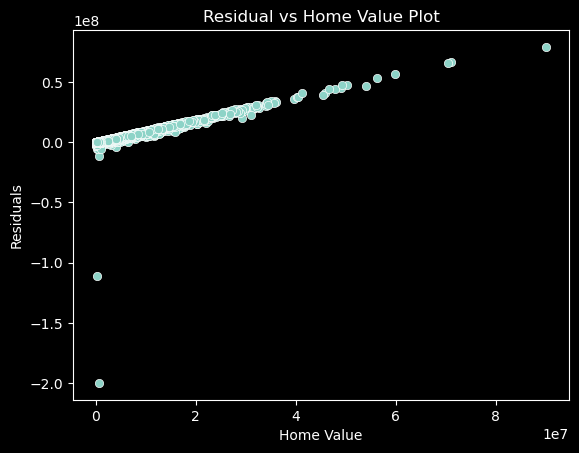

In [81]:
#make scatterplot of y-value vs residuals
sns.scatterplot(data=train, x='taxvalue', y='residuals')

plt.xlabel('Home Value')
plt.ylabel('Residuals')
plt.title('Residual vs Home Value Plot')
plt.show()

# 4 

## Calculate:
    - sum of squared errors 
    - explained sum of squares 
    - total sum of squares 
    - mean squared error 
    - root mean squared error 
    (for your model)



In [82]:
from sklearn.metrics import mean_squared_error

## MSE - mean squared error 

In [83]:
MSE = mean_squared_error(train.taxvalue, train.yhat)

MSE 

388801306931.72546

## SSE - sum or squared errors


In [84]:
# square each residual value
SSE = MSE * len(train)

SSE

4.6599041919818784e+17

## RMSE - root mean squared eror


In [85]:
RMSE = MSE**.5

RMSE

623539.3387202811

## ESS - explained sum of squares


In [87]:
ESS = ((train.yhat - train.taxvalue.mean())**2).sum()

ESS

1.0284337407794117e+17

## TSS - total sum of squares


In [88]:
TSS = ESS + SSE

TSS

5.68833793276129e+17

# 5
## Calculate:  
    - sum of squared errors
    - mean squared error
    - root mean squared error for the baseline model 
    (i.e. a model that always predicts the average taxvaluedollarcnt amount).



In [89]:
train['baseline'] = train.taxvalue.mean()

train.head(3) # verify 


,area,taxvalue,yhat,residuals,baseline
1567873,0.001309,191578,331576.623967,-139998.623967,461370.07448
1218138,0.001391,1345206,348001.978672,997204.021328,461370.07448
339661,0.001104,356648,290513.237203,66134.762797,461370.07448


## MSE

In [91]:
MSE_baseline = mean_squared_error(train.taxvalue, train.baseline)
MSE_baseline

474609161778.9538

## SSE

In [92]:
SSE_baseline = MSE_baseline * len(train)
SSE_baseline

5.6883379327609126e+17

## RMSE

In [93]:
RMSE_baseline = MSE_baseline**.5
RMSE_baseline

688918.8354073024

# 6 
## Write python code that compares the sum of squared errors for your model against the sum of squared errors for the baseline model and outputs whether or not your model performs better than the baseline model.



In [94]:
train.head(3)

,area,taxvalue,yhat,residuals,baseline
1567873,0.001309,191578,331576.623967,-139998.623967,461370.07448
1218138,0.001391,1345206,348001.978672,997204.021328,461370.07448
339661,0.001104,356648,290513.237203,66134.762797,461370.07448


In [97]:
if SSE < SSE_baseline:
    print('Yes, your model performed better than baseline.')
else:
    print('No, your model performed worse than baseline')

Yes, your model performed better than baseline.


# 7 
## What is the amount of variance explained in your model?



In [98]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

#manually
R2 = ESS / TSS
R2



0.1807968782684785

In [99]:
from sklearn.metrics import r2_score

r2_score(train.taxvalue, train.yhat)


0.18079687826842417

# 8 
## Is your model better than the baseline model?



In [100]:
RMSE_baseline - RMSE

65379.49668702122

# 9
## Create a file named evaluate.py that contains the following functions:

    - plot_residuals(y, yhat): creates a residual plot
    - regression_errors(y, yhat): returns the following values:
    - sum of squared errors (SSE)
    - explained sum of squares (ESS)
    - total sum of squares (TSS)
    - mean squared error (MSE)
    - root mean squared error (RMSE)
    - baseline_mean_errors(y): computes the SSE, MSE, and RMSE for the baseline model
    - better_than_baseline(y, yhat): returns true if your model performs better than the baseline, otherwise false

In [101]:
def plot_residuals(y, yhat):
    residuals = y - yhat
    
    plt.scatter(x=y, y=residuals)
    plt.xlabel('Home Value')
    plt.ylabel('Residuals')
    plt.title('Residual vs Home Value Plot')
    plt.show()

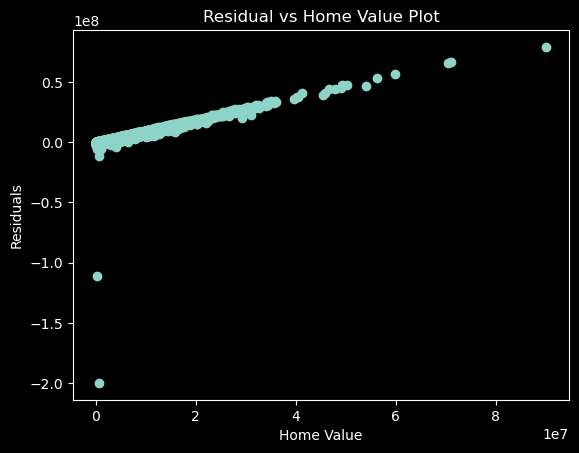

In [104]:
plot_residuals(train.taxvalue, train.yhat)

In [105]:
def regression_errors(y, yhat): # add f strings 
    MSE = mean_squared_error(y, yhat)
    SSE = MSE * len(y)
    RMSE = MSE**.5
    
    ESS = ((yhat - y.mean())**2).sum()
    TSS = ESS + SSE
    
    return SSE, ESS, TSS, MSE, RMSE    

In [107]:
regression_errors(train.taxvalue, train.yhat) 

(4.6599041919818784e+17,
 1.0284337407794117e+17,
 5.68833793276129e+17,
 388801306931.72546,
 623539.3387202811)

In [110]:
def baseline_mean_errors(y): # clearn up to print out nicer 
    baseline = np.repeat(y.mean(), len(y))
    
    MSE = mean_squared_error(y, baseline)
    SSE = MSE * len(y)
    RMSE = MSE**.5
    
    return SSE, MSE, RMSE

In [109]:
baseline_mean_errors(train.yhat)

(1.0284337407794117e+17, 85807854847.25983, 292929.778013878)

In [114]:
def better_than_baseline(y, yhat):
    SSE, ESS, TSS, MSE, RMSE = regression_errors(y, yhat)
    
    SSE_baseline, MSE_baseline, RMSE_baseline = baseline_mean_errors(y)
    
    if SSE < SSE_baseline:
        print('Yes, my model performs better than baseline.')
    else:
        print('No, my model performs worse than baseline.')

In [115]:
better_than_baseline(train.taxvalue, train.yhat)

Yes, my model performs better than baseline.
